# Utils

### Libraries

In [29]:
import numpy as np
import pandas as pd
import os
import glob
import nibabel as nib
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm


In [30]:
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Paths and folders

In [31]:
# FC maps mean
dir_FCmaps = './data/FCmaps_mean_temp/'
dir_FCmaps3D_processed = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps3D_processed'
harvard_oxford_mask = './data_utils/mask_GM.nii'
atrophy_dataset_matches = './data_utils/atrophy_matched.xlsx'
labels_csv = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils'

In [32]:
# Create output directory if it doesn't exist
os.makedirs(dir_FCmaps3D_processed, exist_ok=True)

### Functions

In [5]:
def evaluate_metrics(y_true, y_pred):
    """
    Calculate the evaluation metrics: MSE, RMSE, MAE, and R².
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Data

### Load data

#### Functional Connectivity maps

Load the FC maps data in nii.gz format and extract the subjects identifiers

In [6]:
# Path to the directory containing FC maps
path_dir = os.path.join(dir_FCmaps, '*gz')

# Collects all file paths and sort
## TODO: Check the sorting once we have the data
files=glob.glob(path_dir)
files.sort()

# Extract Subject Identifiers
sub_id = [sub.replace(dir_FCmaps, '') for sub in files]
sub_id = [sub.replace('.FDC.nii.gz', '') for sub in sub_id]

# Create DataFrame from processed subject IDs (See later)
df_ids = pd.DataFrame({'ID': sub_id})

One file example

In [101]:
path_temp = os.join(dir_FCmaps, '1_S_5005.FDC.nii.gz')
temp = nib.load(path_temp).get_fdata()

In [102]:
temp.shape

(91, 109, 91)

Flatten and store each subject’s data (the FC maps)

In [103]:
# Empty list to hold flattened brain maps
maps_FDC=[]

# Loop over files and add the brain maps
for x in range(len(files)):
    print(files[x])
    d=nib.load(files[x]).get_fdata().flatten()
    maps_FDC.append(d)

# Saving affine transformation matrix
aff = nib.load(files[0]).affine

# Create dataframe: stores subjects as rows and voxels as columns
df=pd.DataFrame(maps_FDC)

./data/FCmaps_mean/002_S_4654.FDC.nii.gz
./data/FCmaps_mean/002_S_6695.FDC.nii.gz
./data/FCmaps_mean/003_S_6264.FDC.nii.gz
./data/FCmaps_mean/003_S_6268.FDC.nii.gz
./data/FCmaps_mean/003_S_6432.FDC.nii.gz
./data/FCmaps_mean/003_S_6479.FDC.nii.gz
./data/FCmaps_mean/003_S_6606.FDC.nii.gz
./data/FCmaps_mean/006_S_6252.FDC.nii.gz
./data/FCmaps_mean/006_S_6682.FDC.nii.gz
./data/FCmaps_mean/007_S_6341.FDC.nii.gz
./data/FCmaps_mean/011_S_4893.FDC.nii.gz
./data/FCmaps_mean/011_S_6303.FDC.nii.gz
./data/FCmaps_mean/012_S_4188.FDC.nii.gz
./data/FCmaps_mean/016_S_4902.FDC.nii.gz
./data/FCmaps_mean/016_S_6708.FDC.nii.gz
./data/FCmaps_mean/016_S_6839.FDC.nii.gz
./data/FCmaps_mean/018_S_2155.FDC.nii.gz
./data/FCmaps_mean/019_S_6483.FDC.nii.gz
./data/FCmaps_mean/019_S_6668.FDC.nii.gz
./data/FCmaps_mean/021_S_0626.FDC.nii.gz
./data/FCmaps_mean/021_S_5237.FDC.nii.gz
./data/FCmaps_mean/021_S_6312.FDC.nii.gz
./data/FCmaps_mean/027_S_6965.FDC.nii.gz
./data/FCmaps_mean/032_S_6600.FDC.nii.gz
./data/FCmaps_me

In [104]:
df.shape

(51, 902629)

#### Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [35]:
df_xlsx = pd.read_excel(atrophy_dataset_matches, sheet_name='dataset')
df_xlsx['Age'] = df_xlsx['Age'].round(1)

In [38]:
df_xlsx.head(5)

,ID,Group,Sex,Age,Education,CDR_SB,CDR
0,1_S_5000,CBS,M,70.0,16,5.0,1.0
1,1_S_5001,CBS,F,65.0,16,15.0,3.0
2,1_S_5003,PSP,F,86.0,18,1.0,0.5
3,1_S_5004,PSP,F,67.0,14,1.5,0.5
4,1_S_5005,PSP,F,67.0,20,0.0,0.0


Creating a new CSV with the labels columns we need for the various analysis and the right order

In [107]:
df_labels = pd.merge(df_ids, df_xlsx[['ID', 'Group', 'CDR', 'CDR_SB']], on='ID', how='left')

In [108]:
df_labels.to_csv(os.path.join(dir_FCmaps3D_processed, labels_csv), index=False)

### Preprocessing

#### Thresholding

Set a threshold for values below 0.2 for defining correlation

N.B: the df containing the FD maps will be copied here and the modified without additional copies

In [109]:
df_thr = df.copy()

# Threshold: set all values < 0.2 to 0
df_thr[df_thr < 0.2] = 0

In [110]:
df_thr.iloc[:5,:10]

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
df_thr.shape

(51, 902629)

#### GM Mask

- Binary mask of grey matter using the Harvard-Oxford Atlas

- Keeping the Gray Matter voxels

In [116]:
# Load GM mask and flatten
mask= nib.load(harvard_oxford_mask).get_fdata().flatten()

# Ensure lengths match
assert len(mask) == df_thr.shape[1], "Mask and number of columns do not match"

# Mask
df_thr_masked = df_thr.loc[:, mask != 0]

# Re-index for clarity
df_thr_masked.columns = range(df_thr_masked.shape[1])

In [118]:
df_thr_masked.shape

(51, 55004)

In [119]:
df_thr_masked.iloc[:5,:5]

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


#### Add Labels and Identifiers

In [129]:
# Merge labels into subject IDs
df_temp = pd.merge(df_ids, df_labels, on='ID', how='left')

# Concatenate with the data
df_merged = pd.concat([df_temp, df_thr_masked.drop(columns='ID')], axis=1)

In [130]:
df_merged.head(5)

,ID,Group,CDR,CDR_SB,0,1,2,3,4,5,...,54994,54995,54996,54997,54998,54999,55000,55001,55002,55003
0,002_S_4654,ADNI,0.5,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,002_S_6695,ADNI,0.5,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.217471,0.0,0.0,0.0,0.0,0.203301,0.227984,0.219296,0.0,0.210275
2,003_S_6264,ADNI,0.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,003_S_6268,ADNI,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,003_S_6432,ADNI,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


# Analysis with UMAP

### Input Data

For the further analysis we will remove the ID labels columns, but the order is mantained

In [132]:
# Features selection
X = df_merged.copy()
X = df_merged.drop(columns=['ID', 'Group', 'CDR', 'CDR_SB'])

### Unsupervised Clustering

In [22]:
# Model intialization
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', n_epochs=1000, learning_rate=1.0, init='spectral', min_dist=0.1, spread=1.0, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=1, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, random_state=42, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, transform_seed=42, verbose=False, unique=False)

Reduction

In [23]:
X_umap = reducer.fit_transform(X)

/opt/anaconda3/envs/neuro/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced datasey.

In [24]:
X_umap.shape

(51, 2)

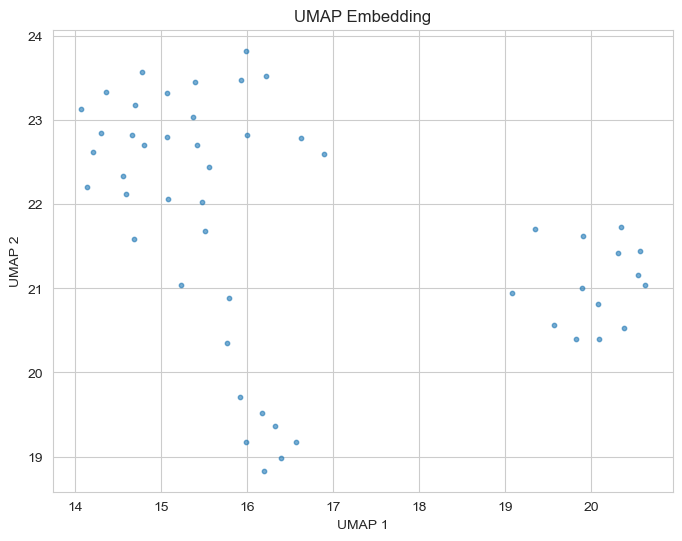

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

Unsupervised clustering

In [26]:
# HDBSCAN
clusterer_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = clusterer_hdb.fit_predict(X_umap)

# DBSCAN
clusterer_db = DBSCAN(eps=0.5, min_samples=5)
labels_db = clusterer_db.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_umap)

#### Plotting

In [27]:
# Dataframe for collecting data for the plotting
labeling_umap = pd.DataFrame({
    'labels_hdb': labels_hdb,  # HDBSCAN clusters
    'labels_db': labels_db,    # DBSCAN clusters
    'labels_km': labels_km,    # K-Means clusters
    'labels_gmm': labels_gmm,  # GMM clusters
    'X1': X_umap[:, 0],        # UMAP component 1
    'X2': X_umap[:, 1],        # UMAP component 2
    'group': df_merged['Group'],        # Diagnosis
    'subject_id': df_merged['ID']       # Identifiers
})

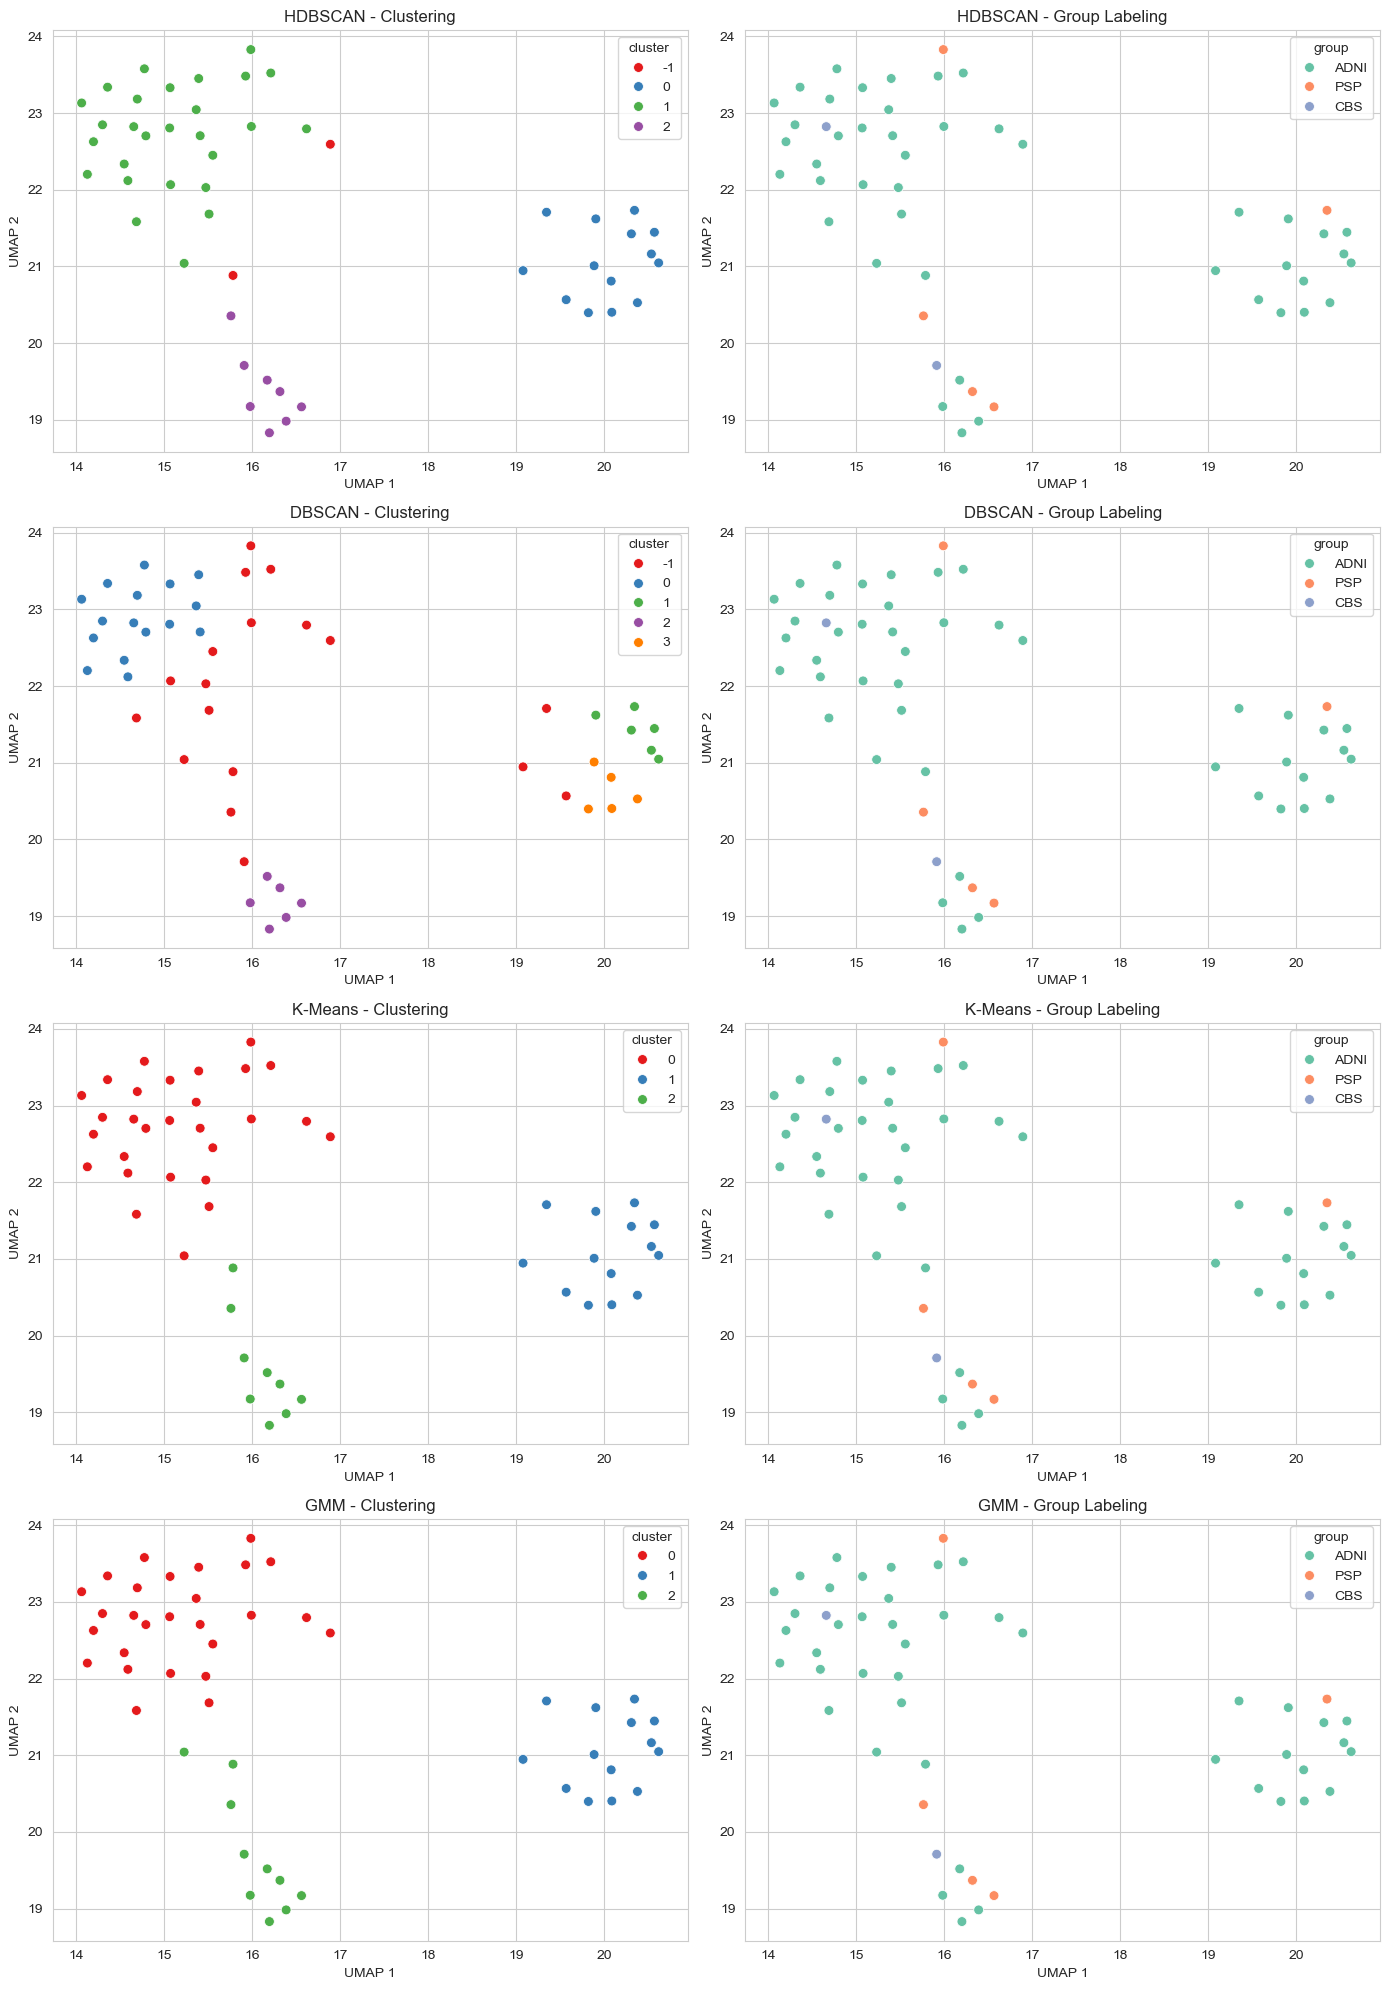

In [28]:
def plot_clusters_vs_groups(X_umap, labels_dict, group_column, figsize=(14, 20)):
    n = len(labels_dict)
    n_cols = 2
    n_rows = n

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Build the subplot
    for i, (title, labels) in enumerate(labels_dict.items()):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        # Plot the left column: color-coded by cluster labels
        plot_df_left = pd.DataFrame({
            'X1': X_umap[:, 0],
            'X2': X_umap[:, 1],
            'cluster': labels,
            'group': group_column
        })

        sns.scatterplot(data=plot_df_left, x='X1', y='X2', hue='cluster', palette='Set1', s=50, ax=ax_left, legend='full')
        ax_left.set_title(f'{title} - Clustering')
        ax_left.set_xlabel("UMAP 1")
        ax_left.set_ylabel("UMAP 2")

        # Plot the right column: color-coded by group labels
        plot_df_right = pd.DataFrame({
            'X1': X_umap[:, 0],
            'X2': X_umap[:, 1],
            'cluster': labels,
            'group': group_column
        })

        sns.scatterplot(data=plot_df_right, x='X1', y='X2', hue='group', palette='Set2', s=50, ax=ax_right, legend='full')
        ax_right.set_title(f'{title} - Group Labeling')
        ax_right.set_xlabel("UMAP 1")
        ax_right.set_ylabel("UMAP 2")

    plt.tight_layout()
    plt.show()

# Dictionary of clustering results
labels_dict = {
    "HDBSCAN": labeling_umap['labels_hdb'],
    "DBSCAN": labeling_umap['labels_db'],
    "K-Means": labeling_umap['labels_km'],
    "GMM": labeling_umap['labels_gmm']
}

# Plot with 4x2 subplots for each technique (left: clustering, right: group)
plot_clusters_vs_groups(X_umap, labels_dict, labeling_umap['group'])

## Regression

Target variable defined

In [29]:
y = df_merged['CDR_SB']

Reduction

In [267]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', n_epochs=1000, learning_rate=1.0, init='spectral', min_dist=0.1, spread=1.0, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=1, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, random_state=42, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, transform_seed=42, verbose=False, unique=False)

In [268]:
X_umap = reducer.fit_transform(X)

/opt/anaconda3/envs/neuro/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Fit  regressions model

In [270]:
# Add a constant to the features
X = sm.add_constant(X_umap)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Display the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     7.758
Date:                Fri, 28 Mar 2025   Prob (F-statistic):            0.00120
Time:                        18:39:58   Log-Likelihood:                -133.56
No. Observations:                  51   AIC:                             273.1
Df Residuals:                      48   BIC:                             278.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.5196     12.367      2.387      0.0

# CNN Classification

## Preprocessing

In [7]:
# Check subject ID and path alignment
for f, sid in zip(files, sub_id):
    assert sid in os.path.basename(f), f"ID mismatch: {sid} not in {f}"

Load the mask

In [8]:
mask = nib.load(harvard_oxford_mask).get_fdata()

The data have been loaded above. Now we will process the FC maps and save them in a 3D format:
- Loading

- Thresholding

- Masking

In [72]:
for file_path, subj_id in zip(files, sub_id):
    # Load 3D FC map
    img = nib.load(file_path).get_fdata()

    # Apply threshold
    img[img < 0.2] = 0

    # Apply GM mask
    assert img.shape == mask.shape, f"Shape mismatch for {subj_id}"
    img[mask == 0] = 0

    # Save to .npy
    out_path = os.path.join(dir_FCmaps3D_processed, f"{subj_id}.npy")
    np.save(out_path, img)

print("All maps processed and saved.")

All maps processed and saved.


## Further analysis

In [23]:
files = glob.glob(os.path.join(dir_FCmaps3D_processed, '*.npy'))

In [28]:
 np.load(files[0]).shape

(91, 109, 91)

In [20]:
mins, maxs, means, stds = [], [], [], []
empty_count = 0

# Loop through each file and calculate statistics
for f in files:
    data = c
    nonzero = data[data != 0]

    if nonzero.size > 0:
        mins.append(nonzero.min())
        maxs.append(nonzero.max())
        means.append(nonzero.mean())
        stds.append(nonzero.std())
    else:
        empty_count += 1
        print(f"All-zero map: {os.path.basename(f)}")

# Print summary
print("-----------------------------")
print(f"Voxel stats across {len(files) - empty_count} valid subjects:")
print(f"- Min:  {np.min(mins):.4f}  and  Max:  {np.max(maxs):.4f}")
print(f"- Mean: {np.mean(means):.4f} ")
print(f"- Std: {np.mean(stds):.4f}")

All-zero map: 007_S_6341.npy
All-zero map: 073_S_6673.npy
All-zero map: 099_S_6691.npy
All-zero map: 1_S_5009.npy
-----------------------------
Voxel stats across 47 valid subjects:
- Min:  0.2000  and  Max:  1.6188
- Mean: 0.2584 
- Std: 0.0515


## Data Augmentation